In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
from torch import nn, optim
import random
from torchvision.transforms import ToTensor, Lambda

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install -q monai

# PLOT FUNCTION

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import time
def training_curve_plot_parameters_dice(title, train_losses, test_losses, train_dice, test_dice, learning_rate, batch_size, num_epochs, training_time):

    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    train_dice = np.array(train_dice)
    test_dice = np.array(test_dice)

    training_time = time.strftime('%M:%S min', time.gmtime(training_time))
    #convenience function for plotting train and test loss and accuracy
    lg = 13
    md = 10
    sm = 9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    main_title = title
    subtitle = f"Batch size: {batch_size} | Learning rate: {learning_rate} | Number of Epochs: {num_epochs} | Training time: {training_time}"
    fig.suptitle(f"{main_title}\n{subtitle}\n\n\n", fontsize = lg)
    fig.subplots_adjust(top=0.80)
    x = range(1, len(train_losses)+1)

    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Epoch', fontsize = md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    #Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    axs[1].plot(x, train_dice, label=f'Final train dice score: {train_dice[-1]*100:.2f}%')
    axs[1].plot(x, test_dice, label=f'Final test dice score: {test_dice[-1]*100:.2f}%')
    axs[1].set_title('Dice Score', fontsize=md)
    axs[1].set_xlabel('Epoch', fontsize=md)
    axs[1].set_ylabel('Dice Score', fontsize = sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    #plt.savefig(title + '.eps', format='eps')
    #plt.savefig(title + '.png', format='png')
    plt.show()

# Dataloader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from torchvision.transforms import functional as TF
dir_path = "/content/drive/MyDrive/DL3/"

class WARWIICK_Dataset_AUGMENTATION(Dataset):
  def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_transform = transforms.Compose([transforms.ToTensor(),
                                                  transforms.ColorJitter(brightness=0.5),
                                                   lambda x: x[:2, :, :] # only use RG Channels
                                                  ])

        self.label_transform = transforms.ToTensor()
        self.images = [file for file in os.listdir(data_dir) if file.startswith('image_')]
        self.labels = [file for file in os.listdir(data_dir) if file.startswith('label_')]

  def __len__(self):
        return len(self.images)

  def __getitem__(self, idx):
      img_name = os.path.join(self.data_dir, self.images[idx])
      img_id = img_name.split('_')[1].split('.')[0]
      label_name = os.path.join(self.data_dir, f"label_{img_id}.png")

      image = Image.open(img_name)
      label = Image.open(label_name)

      # random flip
      seed = torch.randint(0, 10000, (1,)).item()
      torch.manual_seed(seed)
      random_flip = torch.rand(1) < 0.5

      image = transforms.functional.hflip(image)
      label = transforms.functional.hflip(label)

      image = self.image_transform(image)
      label = self.label_transform(label)

      return image, label


class WARWIICK_Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_transform = transforms.Compose([transforms.ToTensor(),
                                                   lambda x: x[:2, :, :],
                                                  ])

        self.label_transform = transforms.ToTensor()
        self.images = [file for file in os.listdir(data_dir) if file.startswith('image_')]
        self.labels = [file for file in os.listdir(data_dir) if file.startswith('label_')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img_name = os.path.join(self.data_dir, self.images[idx])
      img_id = img_name.split('_')[1].split('.')[0]
      label_name = os.path.join(self.data_dir, f"label_{img_id}.png")

      image = Image.open(img_name)
      label = Image.open(label_name)
      image = self.image_transform(image)
      label = self.label_transform(label)

      return image, label

train_dataset = WARWIICK_Dataset(data_dir=dir_path + 'WARWICK/Train/') + WARWIICK_Dataset_AUGMENTATION(data_dir=dir_path + 'WARWICK/Train/')
#train_dataset = WARWIICK_Dataset(data_dir=dir_path + 'WARWICK/Train/')
test_dataset = WARWIICK_Dataset(data_dir=dir_path + 'WARWICK/Test/')


Validation of Dataloading

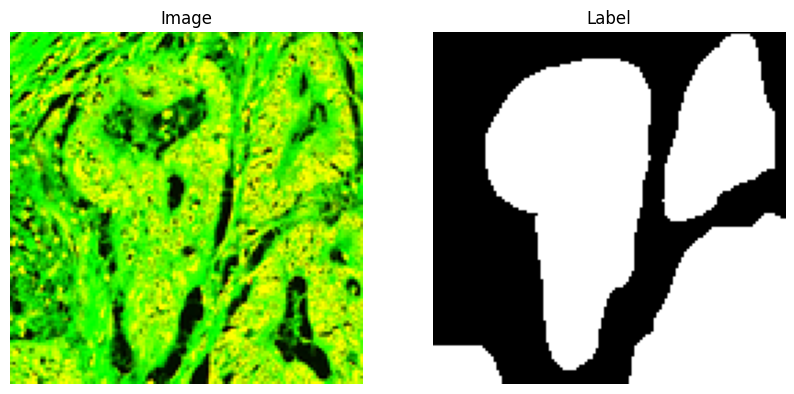

In [6]:
index = random.randint(0, len(train_dataset)-1)
image, label = train_dataset[index]

# recreate a RGB Image
image_rgb = torch.cat((image, torch.zeros_like(image[0:1, :, :])), dim=0)
to_pil = transforms.ToPILImage()
image_pil = to_pil(image_rgb)
label_pil = to_pil(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(label_pil, cmap = 'gray')
axes[1].set_title('Label')
axes[1].axis('off')

plt.show()

In [7]:
print("Image Shape:", image.shape)
print("Label Shape:", label.shape)

Image Shape: torch.Size([2, 128, 128])
Label Shape: torch.Size([1, 128, 128])


# HYPERPARAMETER --------------------------------------------------------------------------------

In [8]:
NUM_EPOCHS = 50
BATCH_SIZE = 4
LEARNING_RATE = 0.001

THRESHOLD = 0.5 #for binary mask

# Dataloader

In [9]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [10]:
len(train_loader), len(test_loader)

(43, 30)

# ARCHITECTURES ------------------------------------------------

# Base CNN Model


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationCNN(nn.Module):
    def __init__(self):
        super(BinaryClassificationCNN, self).__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(2, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        # Additional convolution
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Transposed convolution layers to upsample
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.tconv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.tconv1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.tconv2(x)

        x = torch.sigmoid(x)

        return x

## UNET

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # encoder layers
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # decoder layers
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encode
        c1 = self.encoder_conv1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder_conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder_conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder_conv4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)

        # Decode
        u6 = self.upconv4(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.decoder_conv4(u6)

        u7 = self.upconv3(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.decoder_conv3(u7)

        u8 = self.upconv2(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.decoder_conv2(u8)

        u9 = self.upconv1(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.decoder_conv1(u9)

        output = self.final_conv(c9)

        return torch.sigmoid(output)

# Res-Net based CNN Model (not U-NET)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

class RES_BinaryClassificationCNN(nn.Module):
    def __init__(self):
        super(RES_BinaryClassificationCNN, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.resblock1 = ResidualBlock(256)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.resblock2 = ResidualBlock(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Upsampling layers
        self.tconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.resblock3 = ResidualBlock(128)
        self.tconv2 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.initial(x)
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)

        x = self.tconv1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.resblock3(x)
        x = self.tconv2(x)

        x = torch.sigmoid(x)
        return x


## Res-U-NET

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        identity = x
        out = self.conv(x)
        out += identity
        return F.relu(out)

class RES_UNet(nn.Module):
    def __init__(self):
        super(RES_UNet, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            ResidualBlock(16),
            nn.Dropout(0.1)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            ResidualBlock(32),
            nn.Dropout(0.1)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            nn.Dropout(0.2)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            nn.Dropout(0.2)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # Decoder layers
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)


    def forward(self, x):
        # Encode
        c1 = self.encoder_conv1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder_conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder_conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder_conv4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)

        # Decode
        u6 = self.upconv4(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.decoder_conv4(u6)

        u7 = self.upconv3(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.decoder_conv3(u7)

        u8 = self.upconv2(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.decoder_conv2(u8)

        u9 = self.upconv1(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.decoder_conv1(u9)

        output = self.final_conv(c9)

        return torch.sigmoid(output)

In [45]:
#CHOOSE MODE
mode_dic = ['Basic-CNN', 'UNET', 'ResNet', 'ResUNET']
mode = random.choice(mode_dic)

if mode == 'Basic-CNN':
  model = BinaryClassificationCNN().to(DEVICE)
elif mode == 'UNET':
  model = UNet().to(DEVICE)
elif mode == 'ResNet':
  model = RES_BinaryClassificationCNN().to(DEVICE)
else:
  model = RES_UNet().to(DEVICE)

# Test Model
input_image = torch.rand((1, 2, 128, 128)).to(DEVICE)
output_mask = model(input_image)
print(output_mask)
print(f'Expected output shape: [1, 1, 128, 128], Actual output shape: {output_mask.shape}')

tensor([[[[0.5490, 0.5268, 0.5247,  ..., 0.5334, 0.5259, 0.5304],
          [0.5369, 0.5417, 0.5263,  ..., 0.5433, 0.5380, 0.5291],
          [0.5423, 0.5316, 0.5053,  ..., 0.5334, 0.5111, 0.5125],
          ...,
          [0.5275, 0.5424, 0.5189,  ..., 0.5404, 0.5355, 0.5337],
          [0.5269, 0.5312, 0.5368,  ..., 0.5404, 0.5366, 0.5327],
          [0.5319, 0.5367, 0.5362,  ..., 0.5253, 0.5289, 0.5357]]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
Expected output shape: [1, 1, 128, 128], Actual output shape: torch.Size([1, 1, 128, 128])


In [46]:
mode

'UNET'

# TRAINING

In [47]:
import monai
from monai.metrics import DiceMetric
import time
THRESHOLD = 0.5
best_case = {'dice_score': float('-inf')}
worst_case = {'dice_score': float('inf')}

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_type = ['BCE', 'DiceLoss']
loss_mode  = random.choice(loss_type)
if loss_mode == 'BCE':
  seg_loss = torch.nn.BCEWithLogitsLoss()
else:
  seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
  dice_metric = DiceMetric(include_background=False, reduction='mean')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

train_losses, test_losses = [], []
train_dice, test_dice = [], []

# Evaluation before Training


In [48]:
def evaluate_model_with_dice(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_dice_score = 0.0
    total_images = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            preds = (outputs > THRESHOLD).float()

            loss = seg_loss(outputs, labels)
            total_loss += loss.item() * images.size(0)

            # Dice Score Berechnung
            dice_metric(preds, labels)
            current_dice_score = dice_metric.aggregate().item()
            total_dice_score += current_dice_score

            total_images += images.size(0)
            dice_metric.reset()

    avg_loss = total_loss / total_images
    avg_dice_score = total_dice_score / len(data_loader)
    return avg_loss, avg_dice_score

initial_train_loss, initial_train_dice = evaluate_model_with_dice(model, train_loader, seg_loss, DEVICE)
initial_test_loss, initial_test_dice = evaluate_model_with_dice(model, test_loader, seg_loss, DEVICE)

train_losses.append(initial_train_loss)
train_dice.append(initial_train_dice)
test_losses.append(initial_test_loss)
test_dice.append(initial_test_dice)

print(f'Epoch 0 - Train Loss: {initial_train_loss:.4f}, Train Dice: {initial_train_dice:.4f}, Test Loss: {initial_test_loss:.4f}, Test Dice: {initial_test_dice:.4f}')

Epoch 0 - Train Loss: 1.0439, Train Dice: 0.6528, Test Loss: 1.0581, Test Dice: 0.6421


# TRAINING AND VALIDATION LOOP

In [49]:
start_time = time.time()
n_total_steps = len(train_loader)
total_images_trained = 0
total_images_tested = 0

for epoch in range(NUM_EPOCHS):
  model.train()
  dice_metric.reset()
  total_train_loss = 0.0
  total_train_dice = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)
    preds = (outputs > THRESHOLD).float()
    loss = seg_loss(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item() * images.size(0)
    total_images_trained += images.size(0)

    # Dice Score
    dice_metric(preds, labels)
    current_dice_score = dice_metric.aggregate().item()
    total_train_dice += current_dice_score
    dice_metric.reset()

  avg_train_loss  = total_train_loss / total_images_trained
  avg_train_dice  = total_train_dice / len(train_loader)
  train_losses.append(avg_train_loss)
  train_dice.append(avg_train_dice)

  # Testphase
  model.eval()
  dice_metric.reset()
  total_test_loss = 0.0
  total_test_dice = 0.0
  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          outputs = model(images)
          preds = (outputs > THRESHOLD).float()

          loss = seg_loss(outputs, labels)
          total_test_loss += loss.item() * images.size(0)
          total_images_tested += images.size(0)

          current_dice_score = dice_metric(preds, labels)
          if epoch > NUM_EPOCHS - NUM_EPOCHS/4:
            for j in range(images.size(0)):
              comp_dice_score = current_dice_score[j]
              if comp_dice_score > best_case['dice_score']:
                  best_case.update({
                      'dice_score': comp_dice_score,
                      'image': images[j].cpu(),
                      'ground_truth': labels[j].cpu(),
                      'output': preds[j].cpu()
                  })
              if comp_dice_score < worst_case['dice_score']:
                  worst_case.update({
                      'dice_score': comp_dice_score,
                      'image': images[j].cpu(),
                      'ground_truth': labels[j].cpu(),
                      'output': preds[j].cpu()
                  })

          current_dice_score = dice_metric.aggregate().item()
          total_test_dice += current_dice_score
          dice_metric.reset()

  #avg_test_loss = test_loss / len(test_loader.dataset)
  avg_test_loss = total_test_loss / total_images_tested
  avg_test_dice = total_test_dice / len(test_loader)
  test_losses.append(avg_test_loss)
  test_dice.append(avg_test_dice)

  print(f'Epoch {epoch+1}/{NUM_EPOCHS} - Train loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Test loss: {avg_test_loss:.4f}, Test Dice: {avg_test_dice:.4f}')

end_time = time.time()
total_training_time = end_time - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1/50 - Train loss: 0.9826, Train Dice: 0.4981, Test loss: 1.0549, Test Dice: 0.6375
Epoch 2/50 - Train loss: 0.4468, Train Dice: 0.6768, Test loss: 0.4803, Test Dice: 0.6941
Epoch 3/50 - Train loss: 0.2910, Train Dice: 0.7295, Test loss: 0.3085, Test Dice: 0.7331
Epoch 4/50 - Train loss: 0.2128, Train Dice: 0.7681, Test loss: 0.2191, Test Dice: 0.7180
Epoch 5/50 - Train loss: 0.1674, Train Dice: 0.7963, Test loss: 0.1778, Test Dice: 0.7647
Epoch 6/50 - Train loss: 0.1398, Train Dice: 0.7877, Test loss: 0.1544, Test Dice: 0.7694
Epoch 7/50 - Train loss: 0.1210, Train Dice: 0.7880, Test loss: 0.1250, Test Dice: 0.7009
Epoch 8/50 - Train loss: 0.1025, Train Dice: 0.8233, Test loss: 0.1071, Test Dice: 0.8232
Epoch 9/50 - Train loss: 0.0920, Train Dice: 0.8044, Test loss: 0.0973, Test Dice: 0.7428
Epoch 10/50 - Train loss: 0.0820, Train Dice: 0.8220, Test loss: 0.0885, Test Dice: 0.7120
Epoch 11/50 - Train loss: 0.0744, Train Dice: 0.8214, Test loss: 0.0784, Test Dice: 0.7633
Epoch 12

In [50]:
best_case

{'dice_score': tensor([0.9711], device='cuda:0'),
 'image': tensor([[[0.0588, 0.0431, 0.0392,  ..., 0.1765, 0.2627, 0.0824],
          [0.0314, 0.1137, 0.0471,  ..., 0.2235, 0.2039, 0.0941],
          [0.0039, 0.0667, 0.1333,  ..., 0.1725, 0.3098, 0.1647],
          ...,
          [0.0275, 0.0118, 0.0118,  ..., 0.2549, 0.4784, 0.1647],
          [0.0196, 0.0118, 0.0157,  ..., 0.4157, 0.1686, 0.0588],
          [0.0118, 0.0157, 0.0235,  ..., 0.2392, 0.1059, 0.0667]],
 
         [[0.3255, 0.3255, 0.4784,  ..., 0.4275, 0.6902, 0.6549],
          [0.2902, 0.3529, 0.2510,  ..., 0.5686, 0.6941, 0.6627],
          [0.1490, 0.4235, 0.4667,  ..., 0.5922, 0.6824, 0.6824],
          ...,
          [0.0353, 0.0471, 0.0431,  ..., 0.5922, 0.6745, 0.6392],
          [0.0431, 0.0471, 0.0431,  ..., 0.6314, 0.6235, 0.5804],
          [0.0588, 0.0471, 0.0471,  ..., 0.6078, 0.5843, 0.5608]]]),
 'ground_truth': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0.

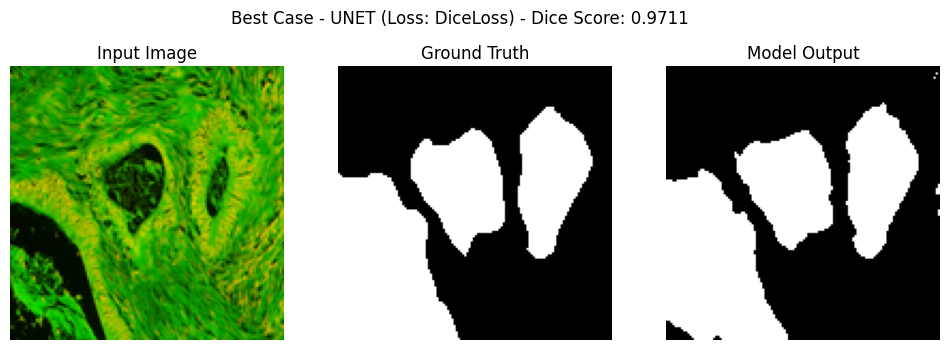

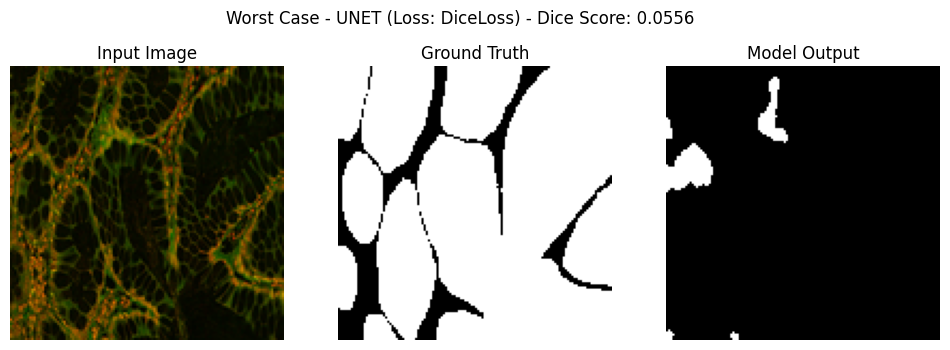

In [51]:
# Function to plot the results
def plot_case(case, title):

    full_image = torch.cat((case['image'], torch.zeros_like(case['image'][0:1, :, :])), dim=0)
    to_pil = transforms.ToPILImage()
    image_rgb = to_pil(full_image)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image_rgb)  # Assuming image is normalized
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    axs[1].imshow(case['ground_truth'].squeeze(), cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')
    axs[2].imshow(case['output'].squeeze(), cmap='gray')
    axs[2].set_title('Model Output')
    axs[2].axis('off')
    plt.suptitle(f"{title} - Dice Score: {case['dice_score'].item():.4f}")
    #plt.savefig(title + '.eps', format='eps')
    #plt.savefig(title + '.png', format='png')
    plt.show()

plot_case(best_case, f"Best Case - {mode} (Loss: {loss_mode})")
plot_case(worst_case, f"Worst Case - {mode} (Loss: {loss_mode})")

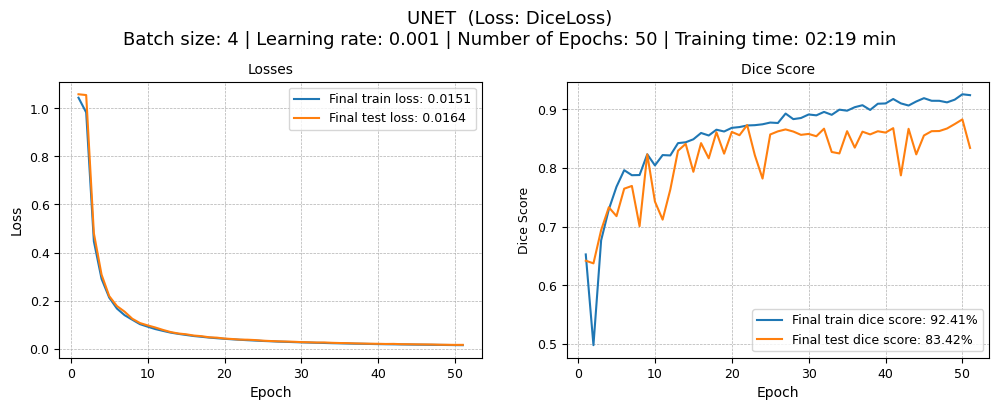

In [52]:
training_curve_plot_parameters_dice(f'{mode}  (Loss: {loss_mode})', train_losses, test_losses, train_dice, test_dice, LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS, total_training_time)